In [21]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, NMF, randomized_svd
from sklearn.metrics import auc, roc_curve, plot_roc_curve, plot_confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from scipy import spatial
from gensim.scripts.glove2word2vec import glove2word2vec 
from gensim.models import KeyedVectors
from tempfile import mkdtemp
from shutil import rmtree
from joblib import Memory
from matplotlib import pyplot as plt
import numpy as np
import random
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
import nltk
import string
from string import punctuation
import os
import pandas as pd
import umap 
import umap.plot
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/swapnilsayansaha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/swapnilsayansaha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/swapnilsayansaha/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Question 1

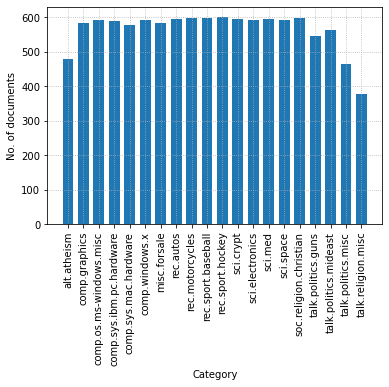

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')
u, inv = np.unique(newsgroups_train.target, return_inverse=True)
plt.bar(u, np.bincount(inv), width=0.7)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(20), np.array(newsgroups_train.target_names),rotation=90)
plt.ylabel('No. of documents')
plt.xlabel('Category')
plt.savefig('Q1.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 2

In [3]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware',
              'comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
train_dataset = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = 42)
test_dataset = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = 42)

In [4]:
lemmatizer = WordNetLemmatizer()
vectorizer = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer = TfidfTransformer()

def penn2morphy(penntag): #reference: discussion notebook
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n' 

def lemmatizer_func(sentence): 
    lemmatized_sen = []
    lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(word_tokenize(sentence))]
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            lemmatized_sen.append(lemma.lower())
    return ' '.join(lemmatized_sen)   

In [5]:
train_data_proc = []
test_data_proc = []
for i in range(len(train_dataset.data)):
    train_data_proc.append(lemmatizer_func(train_dataset.data[i]))
for i in range(len(test_dataset.data)):
    test_data_proc.append(lemmatizer_func(test_dataset.data[i]))
    
train_data_feat_vec = vectorizer.fit_transform(train_data_proc)
test_data_feat_vec = vectorizer.transform(test_data_proc)
train_data_feat = tfidf_transformer.fit_transform(train_data_feat_vec)
test_data_feat = tfidf_transformer.transform(test_data_feat_vec)

In [6]:
print(train_data_feat.shape)
print(test_data_feat.shape)

(4732, 12161)
(3150, 12161)


# Question 3

In [7]:
svd = TruncatedSVD(n_components=50, random_state=42)
nmf = NMF(n_components=50, init='random', random_state=42)

train_data_LSI = svd.fit_transform(train_data_feat)
print('LSI Train Data Shape:', train_data_LSI.shape)
train_data_NMF = nmf.fit_transform(train_data_feat)
print('NMF Train Data Shape:', train_data_NMF.shape)
U_tr,S_tr,V_tr = randomized_svd(train_data_feat,n_components=50,random_state=42)
print('LSI (train) error:',np.sum(np.array(train_data_feat - (U_tr.dot(np.diag(S_tr)).dot(V_tr)))**2))
print('NMF (train) error:',np.sum(np.array(train_data_feat - train_data_NMF.dot(nmf.components_))**2))

test_data_LSI = svd.transform(test_data_feat)
print('LSI Test Data Shape:', test_data_LSI.shape)
test_data_NMF = nmf.transform(test_data_feat)
print('NMF Test Data Shape:', test_data_NMF.shape)
U_te,S_te,V_te = randomized_svd(test_data_feat,n_components=50,random_state=42)
print('LSI (test) error:',np.sum(np.array(test_data_feat - (U_te.dot(np.diag(S_te)).dot(V_te)))**2))
print('NMF (test) error:',np.sum(np.array(test_data_feat - test_data_NMF.dot(nmf.components_))**2))

LSI Train Data Shape: (4732, 50)
NMF Train Data Shape: (4732, 50)
LSI (train) error: 4103.0367390859365
NMF (train) error: 4147.199485161415
LSI Test Data Shape: (3150, 50)
NMF Test Data Shape: (3150, 50)
LSI (test) error: 2643.0475837323024
NMF (test) error: 2858.9878541431635


# Question 4

In [8]:
y_train = []
y_test = []
for label in train_dataset.target:
    if label < 4:
        y_train.append(0)
    else:
        y_train.append(1)
for label in test_dataset.target:
    if label < 4:
        y_test.append(0)
    else:
        y_test.append(1)

In [9]:
clf_hard = svm.SVC(kernel='linear',C=1000,random_state=42)
clf_soft = svm.SVC(kernel='linear',C=0.0001,random_state=42)
pred_hard = clf_hard.fit(train_data_LSI, y_train).predict(test_data_LSI)
pred_soft = clf_soft.fit(train_data_LSI, y_train).predict(test_data_LSI)

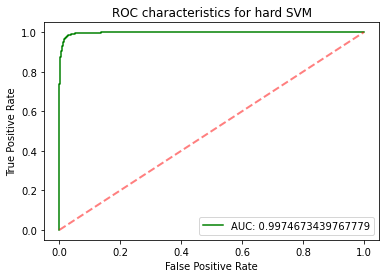

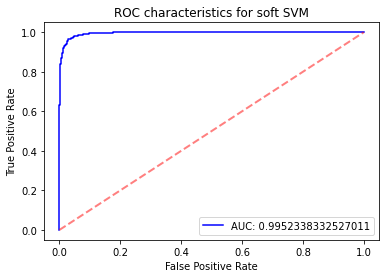

In [56]:
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, clf_hard.decision_function(test_data_LSI))
plot_roc_curve(clf_hard, test_data_LSI, y_test, ax=ax, color='g',label="AUC: "+str(auc(fpr,tpr))) 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.5)
plt.title('ROC characteristics for hard SVM')
plt.savefig('Q41.png',dpi=300,bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, clf_soft.decision_function(test_data_LSI))
plot_roc_curve(clf_soft, test_data_LSI, y_test, ax=ax, color='b',label="AUC: "+str(auc(fpr,tpr))) 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.5)
plt.title('ROC characteristics for soft SVM')
plt.savefig('Q42.png',dpi=300,bbox_inches='tight')
plt.show()

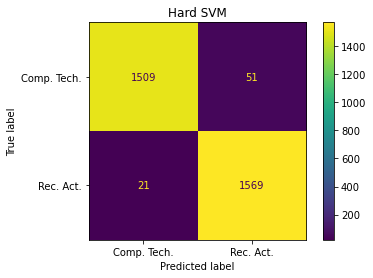

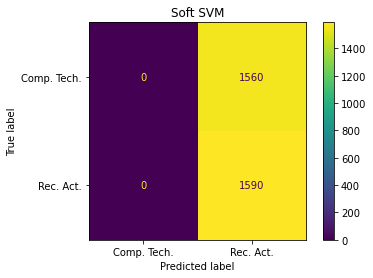

In [28]:
plot_confusion_matrix(clf_hard, test_data_LSI, y_test,display_labels=['Comp. Tech.','Rec. Act.'])
plt.title('Hard SVM')
plt.savefig('Q43.png',dpi=300,bbox_inches='tight')
plt.show()
plot_confusion_matrix(clf_soft, test_data_LSI, y_test,display_labels=['Comp. Tech.','Rec. Act.']) 
plt.title('Soft SVM')
plt.savefig('Q44.png',dpi=300,bbox_inches='tight')
plt.show()

In [29]:
print("Accuracy (hard SVM):", accuracy_score(y_test,pred_hard))
print("Recall (hard SVM):", recall_score(y_test,pred_hard))
print("Precision (hard SVM):", precision_score(y_test,pred_hard))
print("F1-Score (hard SVM):", f1_score(y_test,pred_hard))
print("Accuracy (soft SVM):", accuracy_score(y_test,pred_soft))
print("Recall (soft SVM):", recall_score(y_test,pred_soft))
print("Precision (soft SVM):", precision_score(y_test,pred_soft))
print("F1-Score (soft SVM):", f1_score(y_test,pred_soft))

Accuracy (hard SVM): 0.9771428571428571
Recall (hard SVM): 0.9867924528301887
Precision (hard SVM): 0.9685185185185186
F1-Score (hard SVM): 0.977570093457944
Accuracy (soft SVM): 0.5047619047619047
Recall (soft SVM): 1.0
Precision (soft SVM): 0.5047619047619047
F1-Score (soft SVM): 0.6708860759493671


In [30]:
clf_cv = svm.SVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],  
              'kernel': ['linear']}
grid = GridSearchCV(clf_cv,param_grid,cv=5,scoring='accuracy')
grid.fit(train_data_LSI,y_train)
pred_cv = grid.best_estimator_.predict(test_data_LSI)

In [31]:
print('Best Value of gamma:',grid.best_params_['C']) 
for l, n in zip(param_grid['C'],grid.cv_results_['mean_test_score']):
    print(f'Gamma: {l}\t',f'Avg. Validation Accuracy: {n}')

Best Value of gamma: 400
Gamma: 0.001	 Avg. Validation Accuracy: 0.504860570043154
Gamma: 0.01	 Avg. Validation Accuracy: 0.508875697373033
Gamma: 0.1	 Avg. Validation Accuracy: 0.9632284883162809
Gamma: 1	 Avg. Validation Accuracy: 0.9708359099950663
Gamma: 10	 Avg. Validation Accuracy: 0.976330283012339
Gamma: 100	 Avg. Validation Accuracy: 0.9759070035340264
Gamma: 200	 Avg. Validation Accuracy: 0.9767522229986314
Gamma: 400	 Avg. Validation Accuracy: 0.977174832730934
Gamma: 600	 Avg. Validation Accuracy: 0.9771746094822641
Gamma: 800	 Avg. Validation Accuracy: 0.9769634162404477
Gamma: 1000	 Avg. Validation Accuracy: 0.9771746094822641


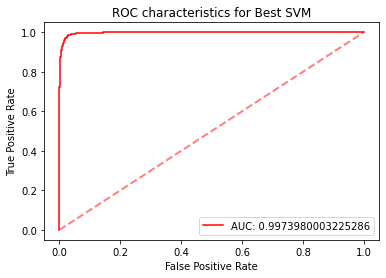

In [55]:
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, grid.best_estimator_.decision_function(test_data_LSI))
plot_roc_curve(grid.best_estimator_, test_data_LSI, y_test, ax=ax, color='r',label="AUC: "+str(auc(fpr,tpr))) 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.5)
plt.title('ROC characteristics for Best SVM')
plt.savefig('Q45.png',dpi=300,bbox_inches='tight')
plt.show()

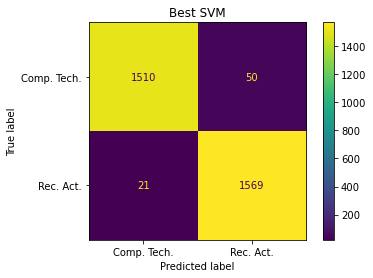

In [33]:
plot_confusion_matrix(grid.best_estimator_, test_data_LSI, y_test,display_labels=['Comp. Tech.','Rec. Act.'])
plt.title('Best SVM')
plt.savefig('Q46.png',dpi=300,bbox_inches='tight')
plt.show()

In [34]:
print("Accuracy (best SVM):", accuracy_score(y_test,pred_cv))
print("Recall (best SVM):", recall_score(y_test,pred_cv))
print("Precision (best SVM):", precision_score(y_test,pred_cv))
print("F1-Score (best SVM):", f1_score(y_test,pred_cv))

Accuracy (best SVM): 0.9774603174603175
Recall (best SVM): 0.9867924528301887
Precision (best SVM): 0.9691167387276096
F1-Score (best SVM): 0.9778747273293862


## Question 5

In [35]:
clf_lr_wor = LogisticRegression(C=1000000,random_state=42,max_iter=100000)
pred_lr_wor = clf_lr_wor.fit(train_data_LSI,y_train).predict(test_data_LSI)

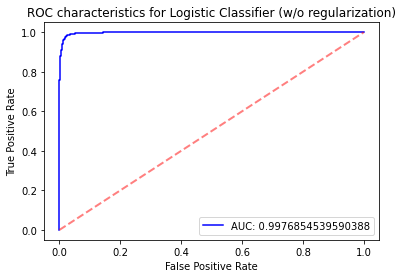

In [54]:
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, clf_lr_wor.decision_function(test_data_LSI))
plot_roc_curve(clf_lr_wor, test_data_LSI, y_test, ax=ax, color='b',label="AUC: "+str(auc(fpr,tpr))) 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.5)
plt.title('ROC characteristics for Logistic Classifier (w/o regularization)')
plt.savefig('Q51.png',dpi=300,bbox_inches='tight')
plt.show()

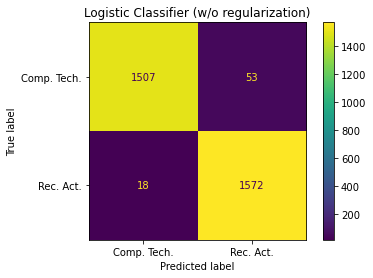

In [37]:
plot_confusion_matrix(clf_lr_wor, test_data_LSI, y_test,display_labels=['Comp. Tech.','Rec. Act.'])
plt.title('Logistic Classifier (w/o regularization)')
plt.savefig('Q52.png',dpi=300,bbox_inches='tight')
plt.show()

In [38]:
print("Accuracy (Logistic Classifier - w/o regularization):", accuracy_score(y_test,pred_lr_wor))
print("Recall (Logistic Classifier - w/o regularization):", recall_score(y_test,pred_lr_wor))
print("Precision (Logistic Classifier - w/o regularization):", precision_score(y_test,pred_lr_wor))
print("F1-Score (Logistic Classifier - w/o regularization):", f1_score(y_test,pred_lr_wor))

Accuracy (Logistic Classifier - w/o regularization): 0.9774603174603175
Recall (Logistic Classifier - w/o regularization): 0.9886792452830189
Precision (Logistic Classifier - w/o regularization): 0.9673846153846154
F1-Score (Logistic Classifier - w/o regularization): 0.9779160186625194


In [39]:
clf_lr_l1 = LogisticRegression(penalty='l1',random_state=42,solver='liblinear',max_iter=100000)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000]}
grid_l1 = GridSearchCV(clf_lr_l1,param_grid,cv=5,scoring='accuracy')
grid_l1.fit(train_data_LSI,y_train)
pred_cv_lr_l1 = grid_l1.best_estimator_.predict(test_data_LSI)

clf_lr_l2 = LogisticRegression(penalty='l2',solver='liblinear',random_state=42)
grid_l2 = GridSearchCV(clf_lr_l2,param_grid,cv=5,scoring='accuracy')
grid_l2.fit(train_data_LSI,y_train)
pred_cv_lr_l2 = grid_l2.best_estimator_.predict(test_data_LSI)

In [40]:
print('Best Value of L1 Regularization Parameter:',grid_l1.best_params_['C']) 
for l, n in zip(param_grid['C'],grid_l1.cv_results_['mean_test_score']):
    print(f'L1 Reg. Param.: {l}\t',f'Avg. Validation Accuracy: {n}')
    
print('Best Value of L2 Regularization Parameter:',grid_l2.best_params_['C']) 
for l, n in zip(param_grid['C'],grid_l2.cv_results_['mean_test_score']):
    print(f'L2 Reg. Param.: {l}\t',f'Avg. Validation Accuracy: {n}')

Best Value of L1 Regularization Parameter: 10
L1 Reg. Param.: 0.001	 Avg. Validation Accuracy: 0.495139429956846
L1 Reg. Param.: 0.01	 Avg. Validation Accuracy: 0.9363890867120158
L1 Reg. Param.: 0.1	 Avg. Validation Accuracy: 0.9518178022954429
L1 Reg. Param.: 1	 Avg. Validation Accuracy: 0.9702023302696174
L1 Reg. Param.: 10	 Avg. Validation Accuracy: 0.9780204986928791
L1 Reg. Param.: 100	 Avg. Validation Accuracy: 0.977174832730934
L1 Reg. Param.: 200	 Avg. Validation Accuracy: 0.9773862492214203
L1 Reg. Param.: 400	 Avg. Validation Accuracy: 0.9775976657119065
L1 Reg. Param.: 600	 Avg. Validation Accuracy: 0.9773862492214203
L1 Reg. Param.: 800	 Avg. Validation Accuracy: 0.9773862492214203
L1 Reg. Param.: 1000	 Avg. Validation Accuracy: 0.9773862492214203
Best Value of L2 Regularization Parameter: 400
L2 Reg. Param.: 0.001	 Avg. Validation Accuracy: 0.7499996651269951
L2 Reg. Param.: 0.01	 Avg. Validation Accuracy: 0.9448437370934363
L2 Reg. Param.: 0.1	 Avg. Validation Accuracy: 

In [41]:
print("Accuracy (best logistic classifer with L1 regularization):", accuracy_score(y_test,pred_cv_lr_l1 ))
print("Recall (best logistic classifer with L1 regularization):", recall_score(y_test,pred_cv_lr_l1 ))
print("Precision (best logistic classifer with L1 regularization):", precision_score(y_test,pred_cv_lr_l1 ))
print("F1-Score (best logistic classifer with L1 regularization):", f1_score(y_test,pred_cv_lr_l1 ))
print("Accuracy (best logistic classifer with L2 regularization):", accuracy_score(y_test,pred_cv_lr_l2 ))
print("Recall (best logistic classifer with L2 regularization):", recall_score(y_test,pred_cv_lr_l2 ))
print("Precision (best logistic classifer with L2 regularization):", precision_score(y_test,pred_cv_lr_l2 ))
print("F1-Score (best logistic classifer with L2 regularization):", f1_score(y_test,pred_cv_lr_l2))

Accuracy (best logistic classifer with L1 regularization): 0.9768253968253968
Recall (best logistic classifer with L1 regularization): 0.9886792452830189
Precision (best logistic classifer with L1 regularization): 0.9661954517516902
F1-Score (best logistic classifer with L1 regularization): 0.9773080509791732
Accuracy (best logistic classifer with L2 regularization): 0.9765079365079365
Recall (best logistic classifer with L2 regularization): 0.9886792452830189
Precision (best logistic classifer with L2 regularization): 0.9656019656019657
F1-Score (best logistic classifer with L2 regularization): 0.9770043505282784


In [42]:
C_list = [0.001,0.01,0.1,1,10,100,200,400,600,800,1000]
accu_coeff_l1 = []
mean_coeff_l1 = []
accu_coeff_l2 = []
mean_coeff_l2 = []
for j in C_list:
    clf_lr_l1_coeff = LogisticRegression(C=j,penalty='l1',random_state=42,solver='liblinear',max_iter=100000) 
    pred_lr_l1_coeff = clf_lr_l1_coeff.fit(train_data_LSI,y_train).predict(test_data_LSI)
    accu_coeff_l1.append(accuracy_score(y_test,pred_lr_l1_coeff))
    mean_coeff_l1.append(np.mean(clf_lr_l1_coeff.coef_))
    clf_lr_l2_coeff = LogisticRegression(C=j,penalty='l2',random_state=42,solver='liblinear') 
    pred_lr_l2_coeff = clf_lr_l2_coeff.fit(train_data_LSI,y_train).predict(test_data_LSI)
    accu_coeff_l2.append(accuracy_score(y_test,pred_lr_l2_coeff))
    mean_coeff_l2.append(np.mean(clf_lr_l2_coeff.coef_))

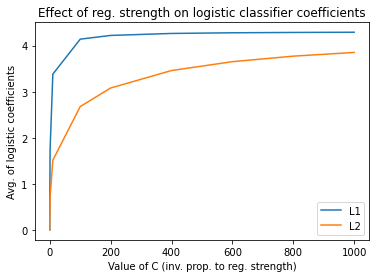

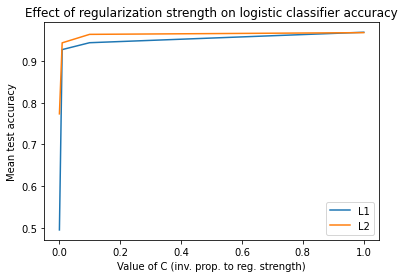

In [43]:
fig, ax = plt.subplots()
plt.title('Effect of reg. strength on logistic classifier coefficients')
plt.plot(C_list,mean_coeff_l1,label='L1')
plt.plot(C_list,mean_coeff_l2,label='L2')
plt.xlabel('Value of C (inv. prop. to reg. strength)')
plt.ylabel('Avg. of logistic coefficients')
plt.legend()
plt.savefig('Q53.png',dpi=300,bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()
plt.title('Effect of regularization strength on logistic classifier accuracy')
plt.plot(C_list[0:4],accu_coeff_l1[0:4],label='L1')
plt.plot(C_list[0:4],accu_coeff_l2[0:4],label='L2')
plt.xlabel('Value of C (inv. prop. to reg. strength)')
plt.ylabel('Mean test accuracy')
plt.legend()
plt.savefig('Q54.png',dpi=300,bbox_inches='tight')
plt.show()

In [44]:
print(np.mean(grid_l1.best_estimator_.coef_))
print(np.mean(grid_l2.best_estimator_.coef_))

3.3813965396277426
3.4593770888580417


## Question 6

In [45]:
clf_NB = GaussianNB()
pred_NB = clf_NB.fit(train_data_LSI, y_train).predict(test_data_LSI)

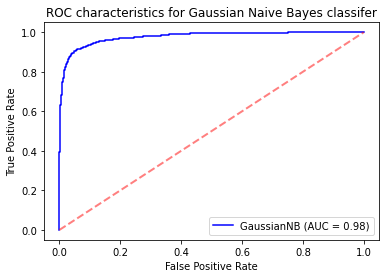

In [48]:
fig, ax = plt.subplots()
plot_roc_curve(clf_NB, test_data_LSI, y_test, ax=ax, color='b') 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.5)
plt.title('ROC characteristics for Gaussian Naive Bayes classifer')
plt.savefig('Q61.png',dpi=300,bbox_inches='tight')
plt.show()

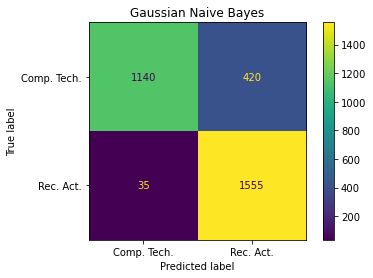

In [30]:
plot_confusion_matrix(clf_NB, test_data_LSI, y_test,display_labels=['Comp. Tech.','Rec. Act.'])
plt.title('Gaussian Naive Bayes')
plt.savefig('Q62.png',dpi=300,bbox_inches='tight')
plt.show()

In [31]:
print("Accuracy (Gaussian Naive Bayes):", accuracy_score(y_test,pred_NB))
print("Recall (Gaussian Naive Bayes):", recall_score(y_test,pred_NB))
print("Precision (Gaussian Naive Bayes):", precision_score(y_test,pred_NB))
print("F1-Score (Gaussian Naive Bayes):", f1_score(y_test,pred_NB))

Accuracy (Gaussian Naive Bayes): 0.8555555555555555
Recall (Gaussian Naive Bayes): 0.9779874213836478
Precision (Gaussian Naive Bayes): 0.7873417721518987
F1-Score (Gaussian Naive Bayes): 0.8723702664796633


## Question 7

In [32]:
def lemmatized(sentence):
    lemmatized_sen = []
    lemma_list = [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag)) 
                  for word, tag in pos_tag(word_tokenize(sentence))]
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            lemmatized_sen.append(lemma.lower())
    return lemmatized_sen

def non_lemmatized(sentence):
    non_lemmatized_sen = []
    lemma_list = word_tokenize(sentence)
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            non_lemmatized_sen.append(lemma.lower())  
    return non_lemmatized_sen

In [33]:
cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=10)

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', None),
    ('clf', None),
],
memory=memory
)
param_grid = [
    {
        'vect__min_df': (3,5),
        'vect__analyzer': (lemmatized,non_lemmatized),
        'reduce_dim': (TruncatedSVD(n_components=50, random_state=42), NMF(n_components=50, init='random', random_state=42)), 
        'clf': (svm.SVC(kernel='linear',C=400,random_state=42),
                GaussianNB(),
                LogisticRegression(penalty='l1',C=10,random_state=42,solver='liblinear',max_iter=100000),
                LogisticRegression(C=400,penalty='l2',random_state=42,solver='liblinear')),  
    }
]

In [34]:
train_dataset_nhf = fetch_20newsgroups(subset = 'train', categories = categories,shuffle = True, random_state = 42,remove=('headers','footers'))
test_dataset_nhf = fetch_20newsgroups(subset = 'test', categories = categories,shuffle = True, random_state = 42,remove=('headers','footers'))
y_train_nhf = []
y_test_nhf = []
for label in train_dataset_nhf.target:
    if label < 4:
        y_train_nhf.append(0)
    else:
        y_train_nhf.append(1)
for label in test_dataset_nhf.target:
    if label < 4:
        y_test_nhf.append(0)
    else:
        y_test_nhf.append(1)

In [35]:
grid_all_nhf = GridSearchCV(pipeline,cv=5,param_grid=param_grid,scoring='accuracy')
grid_all_nhf.fit(train_dataset_nhf.data, y_train_nhf)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckling from bigots on the opposing teams and in the stands, but\n'
  'it never seemed to affect his performance negatively.',
  'On March 21, 1993 Roger Maynard wrote (in reply to an article by Graham\n'
  'Hudson):\n'
  '\n'
  '>> will still have the Jennings Trophy at the end of the year.  Potvin is '
  'very\n'
  '>> good, and I do believe that he will be a star, but I want to see him\n'
  '>> perform in the playoffs under pressure.\n'
  '\n'
  '>You don\'t think he is performing "under pressure" now?  The major\n'
  '>differences  between playoff hockey and normal hockey is 1. play-\n'
  '>ing ever..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=5,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=5,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckling from bigots on the opposing teams and in the stands, but\n'
  'it never seemed to affect his performance negatively.',
  'On March 21, 1993 Roger Maynard wrote (in reply to an article by Graham\n'
  'Hudson):\n'
  '\n'
  '>> will still have the Jennings Trophy at the end of the year.  Potvin is '
  'very\n'
  '>> good, and I do believe that he will be a star, but I want to see him\n'
  '>> perform in the playoffs under pressure.\n'
  '\n'
  '>You don\'t think he is performing "under pressure" now?  The major\n'
  '>differences  between playoff hockey and normal hockey is 1. play-\n'
  '>ing ever..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=5,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=5,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x9216 sparse matrix of type '<class 'numpy.float64'>'
	with 312546 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,


/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dcaf8d2d84058329cf2ba85b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/5f92c6b09b9d94a3bfa050cb4a1eabf9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x9102 sparse matrix of type '<class 'numpy.float64'>'
	with 307728 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1dc6ea7260b56f05dbff0f5d1b90cc8a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/5598cf241de9f18446a03bbea33c6ad0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x9184 sparse matrix of type '<class 'numpy.float64'>'
	with 311229 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/b0dc9f2f80417c726eb7a390e9df04af
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/5404d27b6ea511628590ba07d29f6701
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x9256 sparse matrix of type '<class 'numpy.float64'>'
	with 311669 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/2d7ff6034393092f0ad75cf8134fc778
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/2e09290cc41bca6a7a26d34f7d41385e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x9336 sparse matrix of type '<class 'numpy.float64'>'
	with 311852 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/e611d40d5e74c7c9a8aedf95a5c85c27
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/0e3bcc4f66051afe0b44b4d2da1af3bd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x6047 sparse matrix of type '<class 'numpy.float64'>'
	with 301811 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 6.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6b62bc280af35dbd59b0da62f2268dc4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/8e2e0525d9a2f618893678d06c1be7c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x5987 sparse matrix of type '<class 'numpy.float64'>'
	with 297221 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 6.6s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/b2c399f80c0b2a4b1d06b39184a868ad
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f36c2f80e61cd06b4c6d7078084bdfc0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x6017 sparse matrix of type '<class 'numpy.float64'>'
	with 300468 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 6.9s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/823b9b5ada444d4685e993e1751af496
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/bf479daae33c6a5f574cec6870db159f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x6082 sparse matrix of type '<class 'numpy.float64'>'
	with 300936 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 6.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x11156 sparse matrix of type '<class 'numpy.float64'>'
	with 330633 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d646dbce55fdd808575f024
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/72d7b451aaed4804a44b30bd32813a23
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x11006 sparse matrix of type '<class 'numpy.float64'>'
	with 325211 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9010cc4c95bf0f2f6d331cf5fb98796b
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f541b9352162158ebd07730347ebec3c
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x11138 sparse matrix of type '<class 'numpy.float64'>'
	with 329219 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/518dfb93b874a7baf49793692b66a48f
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/156b056b2be0b25e1c2578370edd1ff0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x11191 sparse matrix of type '<class 'numpy.float64'>'
	with 329465 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/73765f0d07e6945851010497b0583226
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/359d01adea818e9271e3ecac1b877b3d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x11271 sparse matrix of type '<class 'numpy.float64'>'
	with 329663 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/bbb42fd32a2d23f4837f50a0e16d82f3
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/048ed719d2064284534330bfb00f3911
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x7346 sparse matrix of type '<class 'numpy.float64'>'
	with 317693 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 7.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/3d2101b49c715169e3b9a49d9ea884a1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/2ed899a1b566fa3fdfc3a84a480f41ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x7265 sparse matrix of type '<class 'numpy.float64'>'
	with 312602 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 7.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/fa4c0ddfec89bac0c0579a7a1668cb25
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ba37f64191e3407aa65ed4ac4b170c00
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7301 sparse matrix of type '<class 'numpy.float64'>'
	with 316207 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 7.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f8bc1e710f80e77b19ac17847c8b85fd
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/45cb360c2c8dfe7a301220193015df73
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7382 sparse matrix of type '<class 'numpy.float64'>'
	with 316586 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 7.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/fdad0f4aae0bd37a72c3c378180406a7
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a2fccfeaecb8c7fe739884a100989d36
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7416 sparse matrix of type '<class 'numpy.float64'>'
	with 316610 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 7.4s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/429990458598dd244c4e6d56b4289547
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/95f0f075c48419d9d02726cabcca035b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/cfdb7782b76f5c4c577aab6b8bf9c7de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9f3a81e2d86f4ba8ff42e9998636758d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/429990458598dd244c4e6d56b4289547
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/95f0f075c48419d9d02726cabcca035b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/cfdb7782b76f5c4c577aab6b8bf9c7de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9f3a81e2d86f4ba8ff42e9998636758d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/429990458598dd244c4e6d56b4289547
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/95f0f075c48419d9d02726cabcca035b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/742e008d274f06162bfc4bc676177630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/340e2b26b39b4c47c9481009175117ae
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/cfdb7782b76f5c4c577aab6b8bf9c7de
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/51e66125dc

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/726ef23585190cfc9dd4219ebe64467d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/da3cca2247380703ca630b1315be67d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9f3a81e2d86f4ba8ff42e9998636758d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/c0b64b7c0d

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=5,
                stop_words='english'), 
[ 'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> the spot in time to reach his glove up over the short fence, but he\n'
  '|> missed the ball.  A fan sitting in the front row, wearing a ..., 
[ 1,
  1,
  1,
  0,
  

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=/var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib),
                                steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', None), ('clf', None)]),
             param_grid=[{'clf': (SVC(C=400, kernel='linear', random_state=42),
                                  GaussianNB(),
                                  LogisticRegression(C=10, max...
                                                     penalty='l1',
                                                     random_state=42,
                                                     solver='liblinear'),
                                  LogisticRegression(C=400, random_state=42,
                                                     solver='liblinear')),
                       

In [36]:
print(grid_all_nhf.best_estimator_)

Pipeline(memory=Memory(location=/var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib),
         steps=[('vect',
                 CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>,
                                 min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
                ('clf',
                 LogisticRegression(C=400, random_state=42,
                                    solver='liblinear'))])


In [37]:
vectorizer_nhf = CountVectorizer(stop_words='english',min_df=5)
tfidf_transformer_nhf = TfidfTransformer()

train_data_nhf_proc = []
test_data_nhf_proc = []
for i in range(len(train_dataset_nhf.data)):
    train_data_nhf_proc.append(lemmatizer_func(train_dataset_nhf.data[i]))
for i in range(len(test_dataset_nhf.data)):
    test_data_nhf_proc.append(lemmatizer_func(test_dataset_nhf.data[i]))
    
train_data_feat_nhf_vec = vectorizer_nhf.fit_transform(train_data_nhf_proc)
test_data_feat_nhf_vec = vectorizer_nhf.transform(test_data_nhf_proc)
train_data_feat_nhf = tfidf_transformer_nhf.fit_transform(train_data_feat_nhf_vec)
test_data_feat_nhf = tfidf_transformer_nhf.transform(test_data_feat_nhf_vec)
svd_nhf = TruncatedSVD(n_components=50, random_state=42)
train_data_LSI_nhf = svd_nhf.fit_transform(train_data_feat_nhf)
test_data_LSI_nhf = svd_nhf.transform(test_data_feat_nhf)

In [38]:
clf_best_nhf = LogisticRegression(penalty='l2',C=400,solver='liblinear',random_state=42)
pred_best_nhf = clf_best_nhf.fit(train_data_LSI_nhf,y_train_nhf).predict(test_data_LSI_nhf)
print("Test accuracy of best classifier w/o heading and footer in data:", accuracy_score(y_test_nhf,pred_best_nhf))

Test accuracy of best classifier w/o heading and footer in data: 0.966984126984127


In [39]:
grid_all_whf = GridSearchCV(pipeline,cv=5,param_grid=param_grid,scoring='accuracy')
grid_all_whf.fit(train_dataset.data, y_train)

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'Subject: Re: Jewish Baseball Players?\n'
  'From: rbd@flash.ece.uc.edu (Bobby Davis)\n'
  'Organization: University of Cincinnati\n'
  'NNTP-Posting-Host: flash.ece.uc.edu\n'
  'Lines: 5\n'
  '\n'
  'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckling from bigots on the opposing teams and in the stands, but\n'
  'it never seemed to affect his performance negatively.\n'
  '\n'
  'Bob Davis\trbd@thor.ece.uc.edu\n',
  'From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n'
  'Subject: Re: Leaf slump over\n'
  'Nntp-Posting-Host: stpl.ists.ca\n'
  'Organization: Solar Terresterial Physics Laboratory, ISTS\n'
  'Lines: 39\n'
  '\n'
  '\n'
  'On March 21, 199..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=5,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=5,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0,
  

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'Subject: Re: Jewish Baseball Players?\n'
  'From: rbd@flash.ece.uc.edu (Bobby Davis)\n'
  'Organization: University of Cincinnati\n'
  'NNTP-Posting-Host: flash.ece.uc.edu\n'
  'Lines: 5\n'
  '\n'
  'Hank Greenberg was probably the greatest ever.  He was also subject to a\n'
  'lot of heckling from bigots on the opposing teams and in the stands, but\n'
  'it never seemed to affect his performance negatively.\n'
  '\n'
  'Bob Davis\trbd@thor.ece.uc.edu\n',
  'From: dchhabra@stpl.ists.ca (Deepak Chhabra)\n'
  'Subject: Re: Leaf slump over\n'
  'Nntp-Posting-Host: stpl.ists.ca\n'
  'Organization: Solar Terresterial Physics Laboratory, ISTS\n'
  'Lines: 39\n'
  '\n'
  '\n'
  'On March 21, 199..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=3,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=5,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function non_lemmatized at 0x7fb5c9c96950>, min_df=5,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x10949 sparse matrix of type '<class 'numpy.float64'>'
	with 384278 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  1,
  1,
  0,
  0,
  0,
  1,
  0,
  0,
  1,
  1,
  1,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 10.5s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01fc453bda224196c38f2d537
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/03be915626d5c5aaff72e52f3e3e2a31
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x10799 sparse matrix of type '<class 'numpy.float64'>'
	with 378358 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 10.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/3214ff30bd80fcaff977ae5109182484
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a744848792e41803fe58480622529dda
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x10846 sparse matrix of type '<class 'numpy.float64'>'
	with 382116 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 11.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/dec9fa1112595303e646fac20a7d3438
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/0e8da535f618a95b30e1bd839f9cf48e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x10906 sparse matrix of type '<class 'numpy.float64'>'
	with 382461 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 10.5s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/2e27c9b161c04ebc2d93c93f79792191
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/2ae6d280cdb5a7324e63f707d408b0cd
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x10979 sparse matrix of type '<class 'numpy.float64'>'
	with 383057 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 11.6s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/b66dcd1e0a574f75dff50a2957e5a743
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/5ca10fd04976a4883a34077da0f7d558
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x7256 sparse matrix of type '<class 'numpy.float64'>'
	with 371797 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a8e279d72a7e227f45a038c85a2898af
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/46f4a0a0c94be840e6408cf72929a2b9
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x7149 sparse matrix of type '<class 'numpy.float64'>'
	with 365990 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.0s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/3c255c65e6937befea6b98967e274732
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/4c656a8d11f53dd24d36ab4651a43e84
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7188 sparse matrix of type '<class 'numpy.float64'>'
	with 369694 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.3s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/08597f3a381eeadd710e4f4cee72b427
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/01d677915acf3ae4a577aada34670e11
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7269 sparse matrix of type '<class 'numpy.float64'>'
	with 370103 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 8.2s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/94cee6d9237830c07e846630eee4355c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/b4e58473f02a936b2c1b5f3ad5658195
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x7279 sparse matrix of type '<class 'numpy.float64'>'
	with 370486 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


________________________________________________fit_transform_one - 9.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x13022 sparse matrix of type '<class 'numpy.float64'>'
	with 404250 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 12.3s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16c1247024d4563d7bac561c
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/0c2251e0b43bc672add8fa46d4d3d3b0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x12851 sparse matrix of type '<class 'numpy.float64'>'
	with 397756 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 12.9s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6aa4f41d7c820a923a21f3c3c448cf5a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/4348eb67b7316ac7faec54ba06f8049f
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x12931 sparse matrix of type '<class 'numpy.float64'>'
	with 402024 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 14.8s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/7dcec173f68a83737960c99d36d6a6f1
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/7e157e7cc40e44b36408c9940a905783
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x13031 sparse matrix of type '<class 'numpy.float64'>'
	with 402746 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 10.7s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/71fda57ab9c6ddc820e75a547f1d94f4
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/8672bf66ed94a1f0a9c35b0374ca6c9a
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3785x8509 sparse matrix of type '<class 'numpy.float64'>'
	with 383058 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 11.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/edb805a5ac2018709ac7d346d4efeba2
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/0ea87cc592d1490951ddec43c4f37009
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(init='random', n_components=50, random_state=42), <3786x8662 sparse matrix of type '<class 'numpy.float64'>'
	with 387943 stored elements in Compressed Sparse Row format>, 
[ 1,
  1,
  1,
  0,
  0,
  0,
  0,

/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


_______________________________________________fit_transform_one - 11.2s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9425198bdf5bd0416b7a6859ae3a680e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7b

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/7095d698439182bb0295207e56438b41
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/db6d29327e40a83a8ef44cb293f52149
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9ca191ce289a5a2e2b350f050b71618e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9425198bdf5bd0416b7a6859ae3a680e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/7095d698439182bb0295207e56438b41
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/db6d29327e40a83a8ef44cb293f52149
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9ca191ce289a5a2e2b350f050b71618e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9425198bdf5bd0416b7a6859ae3a680e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/7095d698439182bb0295207e56438b41
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/f2f99bcf0a6284e16332dad87be9b42a
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/6c259f51505db8a32e21e5012c3088d8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/db6d29327e40a83a8ef44cb293f52149
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/ebc0e4b01f

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/a6caef8c3ea9aed7612bfcf2decc891e
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/79caf6a1fb608f2129b0387047bec669
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.2s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/9ca191ce289a5a2e2b350f050b71618e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from /var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib/sklearn/pipeline/_fit_transform_one/1ee61fac16

________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>, min_df=3,
                stop_words='english'), 
[ 'From: sac@asdi.saic.com (Steve A. Conroy x6172)\n'
  'Subject: Re: Darrrrrrrrryl\n'
  'Organization: SAIC\n'
  'Lines: 33\n'
  '\n'
  'In article <mssC5KCru.5Ip@netcom.com>, mss@netcom.com (Mark Singer) '
  'writes:\n'
  '|> \n'
  '|> \n'
  '|> The media is beating the incident at Dodger Stadium on Wednesday to\n'
  "|> death, but I haven't seen anything in rsb yet.\n"
  '|> \n'
  '|> Gerald Perry of the Cardinals pinch hit in the eighth inning with two\n'
  '|> on and his club down by a run.  He stroked a line drive into the\n'
  '|> right field corner.  The ball cleared the three-foot high fence and\n'
  '|> went into the crowd.  Darryl, racing over from right center, got to\n'
  '|> th..., 
[ 1,
  1,
  1,
  0,
  

GridSearchCV(cv=5,
             estimator=Pipeline(memory=Memory(location=/var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib),
                                steps=[('vect',
                                        CountVectorizer(stop_words='english')),
                                       ('tfidf', TfidfTransformer()),
                                       ('reduce_dim', None), ('clf', None)]),
             param_grid=[{'clf': (SVC(C=400, kernel='linear', random_state=42),
                                  GaussianNB(),
                                  LogisticRegression(C=10, max...
                                                     penalty='l1',
                                                     random_state=42,
                                                     solver='liblinear'),
                                  LogisticRegression(C=400, random_state=42,
                                                     solver='liblinear')),
                       

In [40]:
print(grid_all_whf.best_estimator_)

Pipeline(memory=Memory(location=/var/folders/k6/1m9hk1l17pqf2dl7bllzhg0c0000gn/T/tmpbjnhap8p/joblib),
         steps=[('vect',
                 CountVectorizer(analyzer=<function lemmatized at 0x7fb5c9c96710>,
                                 min_df=3, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('reduce_dim', TruncatedSVD(n_components=50, random_state=42)),
                ('clf', SVC(C=400, kernel='linear', random_state=42))])


In [41]:
clf_best_whf = svm.SVC(kernel='linear',C=400,random_state=42)
pred_best_whf = clf_best_whf.fit(train_data_LSI, y_train).predict(test_data_LSI)
print("Test accuracy of best classifier with heading and footer in data:", accuracy_score(y_test,pred_best_whf))

Test accuracy of best classifier with heading and footer in data: 0.9774603174603175


## Question 8 (Part C)

In [42]:
#Place the glove.6B.300d.txt file in a folder named glove in the project directory
embeddings_dict = {}
dimension_of_glove = 300
with open("glove/glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [43]:
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']-embeddings_dict['wife']+embeddings_dict['husband']))
print(np.linalg.norm(embeddings_dict['queen']-embeddings_dict['king']))
print(np.linalg.norm(embeddings_dict['wife']-embeddings_dict['husband']))

6.165036
5.966258
3.1520464


In [44]:
root_folder='.'
glove_folder_name='glove'
glove_filename='glove.6B.300d.txt'
glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, glove_filename))
word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_path, word2vec_output_file)
model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

In [45]:
result = model.similar_by_word("king")
print("king is similar to {}: {:.4f}".format(*result[0]))
result = model.similar_by_word("wife")
print("wife is similar to {}: {:.4f}".format(*result[0]))

king is similar to queen: 0.6336
wife is similar to husband: 0.8646


In [46]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

print(find_closest_embeddings(embeddings_dict["queen"] - embeddings_dict["king"] + embeddings_dict["husband"])[:5])

['husband', 'wife', 'mother', 'daughter', 'grandmother']


## Question 9

In [47]:
def punc_num_remover(sentence):
    non_lemmatized_sen = []
    lemma_list = word_tokenize(sentence)
    for lemma in lemma_list:
        if (not any(char in lemma for char in punctuation) and not any(char.isdigit() for char in lemma)):
            non_lemmatized_sen.append(lemma.lower())  
    return ' '.join(non_lemmatized_sen)

X_train = []
X_test = []
for i in range(len(train_dataset.data)):
    X_train.append(punc_num_remover(train_dataset.data[i]))
for i in range(len(test_dataset.data)):
    X_test.append(punc_num_remover(test_dataset.data[i]))

In [48]:
#Reference: 
#https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html
class Word2VecVectorizer:
    def __init__(self, model):
        print("Loading in word vectors...")
        self.word_vectors = model
        print("Finished loading in word vectors")
    
    def fit(self, data):
        pass
    
    def transform(self, data):
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        emptycount = 0
        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0
            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass
            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                emptycount += 1
            n += 1
        print("Number of samples with no words found: %s / %s" % (emptycount, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [49]:
vectorizer = Word2VecVectorizer(model)

Loading in word vectors...
Finished loading in word vectors


In [50]:
Xtrain = vectorizer.fit_transform(X_train)
Ytrain = y_train
Xtest = vectorizer.transform(X_test)
Ytest = y_test
print(Xtrain.shape,Xtest.shape)

Number of samples with no words found: 0 / 4732
Number of samples with no words found: 0 / 3150
(4732, 300) (3150, 300)


In [51]:
clf_cv_Glove = svm.SVC(random_state=42)
param_grid = {'C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],  
              'kernel': ['linear']}
Glove_model = GridSearchCV(clf_cv_Glove,param_grid,cv=5,scoring='accuracy',n_jobs=-1).fit(Xtrain, Ytrain)
y_pred_glove = Glove_model.best_estimator_.predict(Xtest)

In [52]:
print(Glove_model.best_estimator_)

SVC(C=1, kernel='linear', random_state=42)


In [53]:
print("Accuracy (Best GLoVE classifier):", accuracy_score(Ytest,y_pred_glove))
print("Recall (Best GLoVE classifier):", recall_score(Ytest,y_pred_glove))
print("Precision (Best GLoVE classifier):", precision_score(Ytest,y_pred_glove))
print("F1-Score (Best GLoVE classifier):", f1_score(Ytest,y_pred_glove))

Accuracy (Best GLoVE classifier): 0.9714285714285714
Recall (Best GLoVE classifier): 0.9735849056603774
Precision (Best GLoVE classifier): 0.9699248120300752
F1-Score (Best GLoVE classifier): 0.9717514124293785


## Question 10

In [54]:
filenames_glove = ['glove.6B.50d.txt','glove.6B.100d.txt','glove.6B.200d.txt','glove.6B.300d.txt']
accu_list_glove = []
for filename in filenames_glove:
    print('Training for: ', filename)
    glove_filename=filename
    glove_path = os.path.abspath(os.path.join(root_folder, glove_folder_name, glove_filename))
    word2vec_output_file = glove_filename+'.word2vec'
    glove2word2vec(glove_path, word2vec_output_file)
    model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
    vectorizer = Word2VecVectorizer(model)
    Xtrain = vectorizer.fit_transform(X_train)
    Ytrain = y_train
    Xtest = vectorizer.transform(X_test)
    Ytest = y_test
    clf_cur = svm.SVC(kernel='linear',C=1,random_state=42)
    pred_cur = clf_cur.fit(Xtrain, Ytrain).predict(Xtest)
    accu_list_glove.append(accuracy_score(Ytest,pred_cur))  

Training for:  glove.6B.50d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4732
Number of samples with no words found: 0 / 3150
Training for:  glove.6B.100d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4732
Number of samples with no words found: 0 / 3150
Training for:  glove.6B.200d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4732
Number of samples with no words found: 0 / 3150
Training for:  glove.6B.300d.txt
Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4732
Number of samples with no words found: 0 / 3150


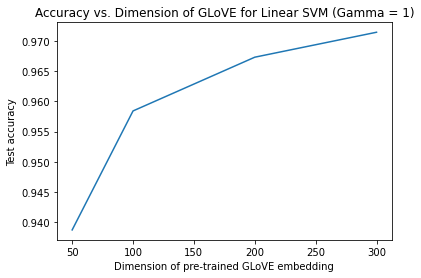

In [55]:
dim_list = [50,100,200,300]
plt.plot(dim_list,accu_list_glove)
plt.title('Accuracy vs. Dimension of GLoVE for Linear SVM (Gamma = 1)')
plt.xlabel('Dimension of pre-trained GLoVE embedding')
plt.ylabel('Test accuracy')
plt.savefig('Q101.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 11

In [56]:
reduced_dim_embedding = umap.UMAP(n_components=2, metric='euclidean').fit(Xtrain)
print(reduced_dim_embedding.embedding_.shape)

(4732, 2)


In [57]:
YtrainTextLabel = []
for label in Ytrain:
    if(label==0):
        YtrainTextLabel.append('Computer Technology')
    else:
        YtrainTextLabel.append('Recreational Activity')

In [58]:
s = np.random.normal(0, 1, [4732,300])
s = s / np.linalg.norm(s)
reduced_dim_s = umap.UMAP(n_components=2, metric='cosine').fit(s)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


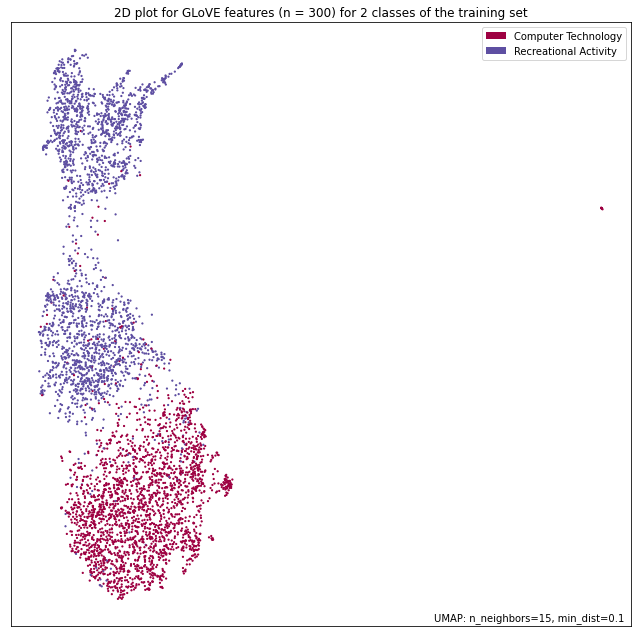

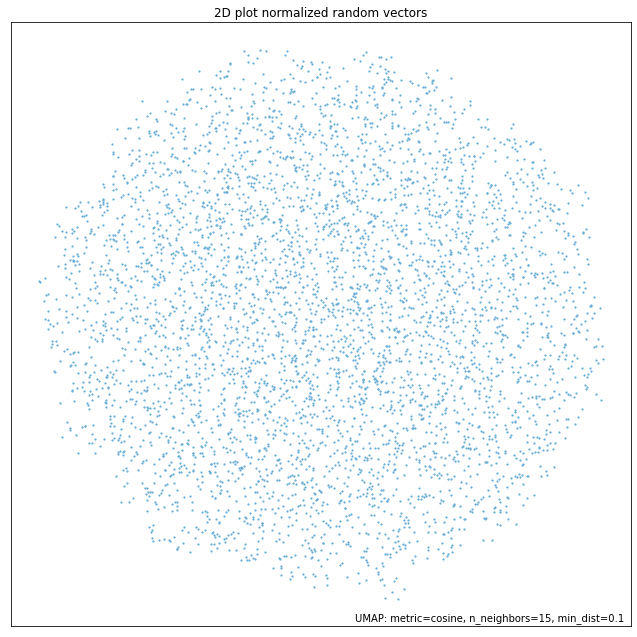

In [59]:
f = umap.plot.points(reduced_dim_embedding, labels=np.array(YtrainTextLabel))
plt.title('2D plot for GLoVE features (n = 300) for 2 classes of the training set')
plt.savefig('Q111.png',dpi=300,bbox_inches='tight')
g = umap.plot.points(reduced_dim_s)
plt.title('2D plot normalized random vectors')
plt.savefig('Q112.png',dpi=300,bbox_inches='tight')
plt.show()

## Question 12

In [73]:
categories_mc = ['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','misc.forsale','soc.religion.christian']
train_dataset_mc = fetch_20newsgroups(subset = 'train', categories = categories_mc,shuffle = True, random_state = 42)
test_dataset_mc = fetch_20newsgroups(subset = 'test', categories = categories_mc,shuffle = True, random_state = 42)

In [76]:
vectorizer_mc = CountVectorizer(stop_words='english',min_df=3)
tfidf_transformer_mc = TfidfTransformer()
train_data_proc_mc = []
test_data_proc_mc = []
for i in range(len(train_dataset_mc.data)):
    train_data_proc_mc.append(lemmatizer_func(train_dataset_mc.data[i]))
for i in range(len(test_dataset_mc.data)):
    test_data_proc_mc.append(lemmatizer_func(test_dataset_mc.data[i]))
    
train_data_feat_vec_mc = vectorizer_mc.fit_transform(train_data_proc_mc)
test_data_feat_vec_mc = vectorizer_mc.transform(test_data_proc_mc)
train_data_feat_mc = tfidf_transformer_mc.fit_transform(train_data_feat_vec_mc)
test_data_feat_mc = tfidf_transformer_mc.transform(test_data_feat_vec_mc)
svd_mc = TruncatedSVD(n_components=50, random_state=42)
train_data_LSI_mc = svd_mc.fit_transform(train_data_feat_mc)
test_data_LSI_mc = svd_mc.transform(test_data_feat_mc)

In [77]:
clf_NB_mc = GaussianNB()
pred_NB_mc = clf_NB_mc.fit(train_data_LSI_mc, train_dataset_mc.target).predict(test_data_LSI_mc)

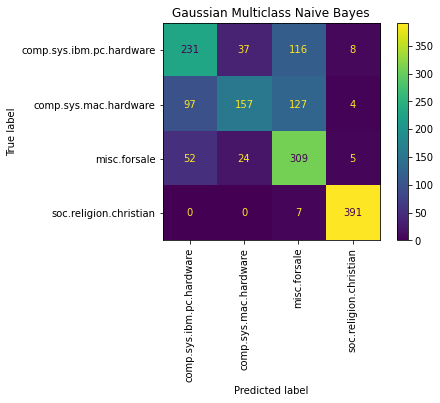

In [78]:
plot_confusion_matrix(clf_NB_mc, test_data_LSI_mc, test_dataset_mc.target,display_labels=categories_mc)
plt.xticks(rotation=90)
plt.title('Gaussian Multiclass Naive Bayes')
plt.savefig('Q121.png',dpi=300,bbox_inches='tight')
plt.show()

In [79]:
print("Accuracy (Multiclass Gaussian Naive Bayes):", accuracy_score(test_dataset_mc.target,pred_NB_mc))
print("Recall (Multiclass Gaussian Naive Bayes):", recall_score(test_dataset_mc.target,pred_NB_mc,average='weighted'))
print("Precision (Multiclass Gaussian Naive Bayes):", precision_score(test_dataset_mc.target,pred_NB_mc,average='weighted'))
print("F1-Score (Multiclass Gaussian Naive Bayes):", f1_score(test_dataset_mc.target,pred_NB_mc,average='weighted'))

Accuracy (Multiclass Gaussian Naive Bayes): 0.6952076677316293
Recall (Multiclass Gaussian Naive Bayes): 0.6952076677316293
Precision (Multiclass Gaussian Naive Bayes): 0.7109031572264817
F1-Score (Multiclass Gaussian Naive Bayes): 0.6870243376226386


In [80]:
clf_svm_mc = OneVsOneClassifier(svm.SVC(random_state=42))
param_grid = {'estimator__C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],  
              'estimator__kernel': ['linear']}
grid_svm_mc = GridSearchCV(clf_svm_mc,param_grid,cv=5,scoring='accuracy')
grid_svm_mc.fit(train_data_LSI_mc, train_dataset_mc.target)
pred_svm_mc = grid_svm_mc.best_estimator_.predict(test_data_LSI_mc)

In [81]:
print(grid_svm_mc.best_estimator_)

OneVsOneClassifier(estimator=SVC(C=10, kernel='linear', random_state=42))


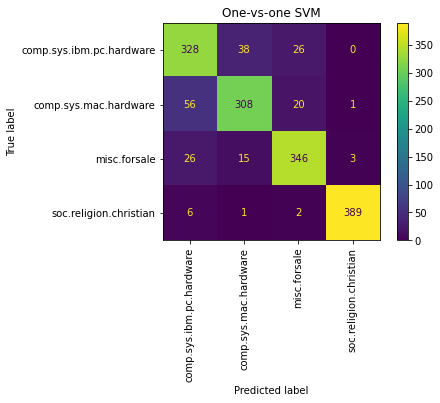

In [82]:
plot_confusion_matrix(grid_svm_mc.best_estimator_, test_data_LSI_mc, test_dataset_mc.target,display_labels=categories_mc)
plt.xticks(rotation=90)
plt.title('One-vs-one SVM')
plt.savefig('Q122.png',dpi=300,bbox_inches='tight')
plt.show()

In [83]:
print("Accuracy (One-vs-one SVM):", accuracy_score(test_dataset_mc.target,pred_svm_mc))
print("Recall (One-vs-one SVM):", recall_score(test_dataset_mc.target,pred_svm_mc,average='weighted'))
print("Precision (One-vs-one SVM):", precision_score(test_dataset_mc.target,pred_svm_mc,average='weighted'))
print("F1-Score (One-vs-one SVM):", f1_score(test_dataset_mc.target,pred_svm_mc,average='weighted'))

Accuracy (One-vs-one SVM): 0.876038338658147
Recall (One-vs-one SVM): 0.876038338658147
Precision (One-vs-one SVM): 0.8773689475462186
F1-Score (One-vs-one SVM): 0.8763158458707359


In [84]:
clf_svm_mc_oa = OneVsRestClassifier(svm.SVC(random_state=42))
param_grid = {'estimator__C': [0.001,0.01,0.1,1,10,100,200,400,600,800,1000],  
              'estimator__kernel': ['linear']}
grid_svm_mc_oa = GridSearchCV(clf_svm_mc_oa,param_grid,cv=5,scoring='accuracy')
grid_svm_mc_oa.fit(train_data_LSI_mc, train_dataset_mc.target)
pred_svm_mc_oa = grid_svm_mc_oa.best_estimator_.predict(test_data_LSI_mc)

In [85]:
print(grid_svm_mc_oa.best_estimator_)

OneVsRestClassifier(estimator=SVC(C=1, kernel='linear', random_state=42))


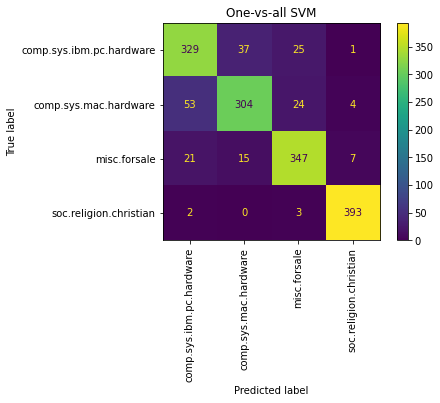

In [86]:
plot_confusion_matrix(grid_svm_mc_oa.best_estimator_, test_data_LSI_mc, test_dataset_mc.target,display_labels=categories_mc)
plt.xticks(rotation=90)
plt.title('One-vs-all SVM')
plt.savefig('Q123.png',dpi=300,bbox_inches='tight')
plt.show()

In [87]:
print("Accuracy (One-vs-all SVM):", accuracy_score(test_dataset_mc.target,pred_svm_mc_oa))
print("Recall (One-vs-all SVM):", recall_score(test_dataset_mc.target,pred_svm_mc_oa,average='weighted'))
print("Precision (One-vs-all SVM):", precision_score(test_dataset_mc.target,pred_svm_mc_oa,average='weighted'))
print("F1-Score (One-vs-all SVM):", f1_score(test_dataset_mc.target,pred_svm_mc_oa,average='weighted'))

Accuracy (One-vs-all SVM): 0.8773162939297124
Recall (One-vs-all SVM): 0.8773162939297124
Precision (One-vs-all SVM): 0.8770504094919451
F1-Score (One-vs-all SVM): 0.876771235927221
